# Acknowledgements

Original Kernel: https://www.kaggle.com/yamsam/ashrae-leak-validation-and-more/notebook#Leak-Validation-for-public-kernels(not-used-leak-data)

Additions: Added a search method to find combination of weights with best score

# All we need is Leak Validation(LV) ?

* **if you like this kernel, please upvote original kernels.**
* update site-4 and site-15

this kernel is still work in progress, but i hope you can find something usefull from this.

In [1]:
import gc
import os
from pathlib import Path
import random
import sys
import glob

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

/Users/numatakouhei/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



In [2]:

# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [118]:
%%time
root = Path('./results')

train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather')
#weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather')

CPU times: user 518 ms, sys: 1.95 s, total: 2.46 s
Wall time: 3.28 s


In [119]:
# i'm now using my leak data station kernel to shortcut.
leak_df = pd.read_feather('leak.feather')

leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]

In [5]:
leak_df.meter.value_counts()

0.0    7512475
1.0    2856222
3.0     963600
2.0     727682
Name: meter, dtype: int64

In [48]:
del train_df
gc.collect()

155

In [16]:
test_df.shape[0] - leak_df.shape[0]

29637621

In [19]:
test_leak = pd.merge(test_df, leak_df, on=['building_id', 'meter', 'timestamp'], how='left', indicator=True)

In [20]:
non_leak = test_leak[test_leak['_merge'] == 'left_only']

In [21]:
non_leak.head()

,row_id,building_id,meter,timestamp,meter_reading,_merge
2260082,2260082,106,3,2017-01-01,NaN,left_only
2260086,2260086,109,3,2017-01-01,NaN,left_only
2260090,2260090,112,3,2017-01-01,NaN,left_only
2260092,2260092,113,3,2017-01-01,NaN,left_only
2260094,2260094,114,3,2017-01-01,NaN,left_only


In [22]:
non_leak.shape

(29637621, 6)

# Leak Validation for public kernels(not used leak data)

In [120]:
all_files = glob.glob('./*.csv')
all_files

['./submission_Highway.csv',
 './submission_Half.csv',
 './submission_KFold.csv',
 './submission_ucf_replaced.csv']

In [121]:
my_all_files = glob.glob('./prediction/*.csv')
my_all_files

['./prediction/submission_noleak_2019-12-17.csv',
 './prediction/submission_2019-12-18_4.csv',
 './prediction/submission_2019-12-18_5.csv',
 './prediction/submission_2019-12-18_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_3.csv',
 './prediction/submission_2019-12-18_2.csv',
 './prediction/submission_2019-12-18_3.csv',
 './prediction/submission_2019-12-19_TargetEnc_2.csv',
 './prediction/submission_2019-12-20_TargetEnc_4.csv',
 './prediction/submission_2019-12-17_1.csv',
 './prediction/submission_noleak_2019-12-18_2.csv',
 './prediction/submission_noleak_2019-12-18.csv']

In [122]:
all_files += my_all_files
all_files

['./submission_Highway.csv',
 './submission_Half.csv',
 './submission_KFold.csv',
 './submission_ucf_replaced.csv',
 './prediction/submission_noleak_2019-12-17.csv',
 './prediction/submission_2019-12-18_4.csv',
 './prediction/submission_2019-12-18_5.csv',
 './prediction/submission_2019-12-18_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_1.csv',
 './prediction/submission_2019-12-19_TargetEnc_3.csv',
 './prediction/submission_2019-12-18_2.csv',
 './prediction/submission_2019-12-18_3.csv',
 './prediction/submission_2019-12-19_TargetEnc_2.csv',
 './prediction/submission_2019-12-20_TargetEnc_4.csv',
 './prediction/submission_2019-12-17_1.csv',
 './prediction/submission_noleak_2019-12-18_2.csv',
 './prediction/submission_noleak_2019-12-18.csv']

In [123]:
#outs = [pd.read_csv(all_files[i], index_col=0) for i in range(len(all_files))]
for i in range(len(all_files)):
    df_pred = pd.read_csv(all_files[i], index_col=0)
    test_df[f'pred_{i + 1}'] = df_pred.meter_reading
    del df_pred
    gc.collect()

/Users/numatakouhei/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



sample_submission1 = pd.read_csv('submission_KFold.csv', index_col=0)
sample_submission2 = pd.read_csv('submission_Half.csv', index_col=0)
sample_submission3 = pd.read_csv('submission_Highway.csv', index_col=0)

In [124]:
#test_df['pred1'] = sample_submission1.meter_reading
#test_df['pred2'] = sample_submission2.meter_reading
#test_df['pred3'] = sample_submission3.meter_reading

test_df.loc[test_df.pred_1<0, 'pred_1'] = 0

#del  outs
#gc.collect()

test_df = reduce_mem_usage(test_df)
leak_df = reduce_mem_usage(leak_df)

Memory usage of dataframe is 6004.66 MB
Memory usage after optimization is: 3300.57 MB
Decreased by 45.0%
Memory usage of dataframe is 460.05 MB
Memory usage after optimization is: 299.03 MB
Decreased by 35.0%


In [125]:
test_df.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'pred_1', 'pred_2',
       'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9',
       'pred_10', 'pred_11', 'pred_12', 'pred_13', 'pred_14', 'pred_15',
       'pred_16', 'pred_17'],
      dtype='object')

In [126]:
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5', 'pred_6', 'pred_7', 'pred_8', 'pred_9', 'pred_10', 'pred_11', 'pred_12', 'pred_13', 'pred_14', 'pred_15', 'pred_16', 'pred_17', 'row_id']], left_on = ['building_id', 'meter', 'timestamp'], right_on = ['building_id', 'meter', 'timestamp'], how = "left")
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')
del building_meta_df
gc.collect()

0

In [127]:
for i in range(len(all_files)):
    leak_df[f'pred_{i + 1}_l1p'] = np.log1p(leak_df[f'pred_{i + 1}'])
leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

In [128]:
leak_df.head()

,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p
0,0,0.0,173.370300,2017-01-01,169.533401,92.729485,186.168106,173.370300,186.206650,156.136826,...,5.298637,5.211858,6.473919,4.956094,5.241177,5.299574,4.950320,5.214828,5.220861,5.161181
1,1,0.0,53.512718,2017-01-01,89.669403,41.220722,85.102570,53.512699,89.900093,88.191727,...,4.502389,4.444525,6.719754,4.133663,4.381903,4.489275,4.345823,4.479124,4.521342,3.998434
2,2,0.0,6.143042,2017-01-01,12.904300,2.686540,13.020658,6.143000,6.749013,40.313980,...,2.034007,1.858973,6.561582,2.934580,2.005508,2.094690,2.546166,1.964064,2.089570,1.966139
3,3,0.0,101.701469,2017-01-01,312.110107,139.413605,249.669037,101.701500,304.735504,109.968895,...,5.739752,5.647774,6.650698,5.264287,5.714678,5.788047,5.526220,5.746922,5.705241,4.631826
4,4,0.0,1141.240723,2017-01-01,1359.578369,620.063782,1130.942383,1141.240723,1406.722290,727.747742,...,6.906927,6.944471,6.553182,6.714146,7.038533,6.846213,6.446486,7.274643,7.243464,7.040747


In [129]:
for i in range(len(all_files)):
    display(leak_df[leak_df[f'pred_{i + 1}_l1p'].isnull()])

,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


,building_id,meter,meter_reading,timestamp,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,...,pred_9_l1p,pred_10_l1p,pred_11_l1p,pred_12_l1p,pred_13_l1p,pred_14_l1p,pred_15_l1p,pred_16_l1p,pred_17_l1p,meter_reading_l1p


File name: ./submission_Highway.csv
Score 1 = 0.9965962171554565
File name: ./submission_Half.csv
Score 2 = 1.0053532123565674
File name: ./submission_KFold.csv
Score 3 = 0.9854710698127747
File name: ./submission_ucf_replaced.csv
Score 4 = 0.36369553208351135
File name: ./prediction/submission_noleak_2019-12-17.csv
Score 5 = 0.9920561909675598
File name: ./prediction/submission_2019-12-18_4.csv
Score 6 = 1.0699297189712524
File name: ./prediction/submission_2019-12-18_5.csv
Score 7 = 0.9813950657844543
File name: ./prediction/submission_2019-12-18_1.csv
Score 8 = 1.0842739343643188
File name: ./prediction/submission_2019-12-19_TargetEnc_1.csv
Score 9 = 0.9839401245117188
File name: ./prediction/submission_2019-12-19_TargetEnc_3.csv
Score 10 = 0.978188157081604
File name: ./prediction/submission_2019-12-18_2.csv
Score 11 = 2.4858150482177734
File name: ./prediction/submission_2019-12-18_3.csv
Score 12 = 1.0345211029052734
File name: ./prediction/submission_2019-12-19_TargetEnc_2.csv
Sc

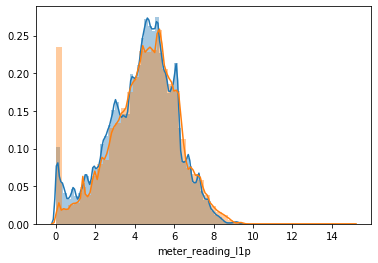

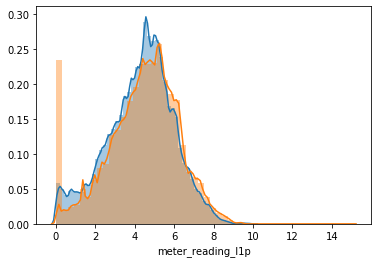

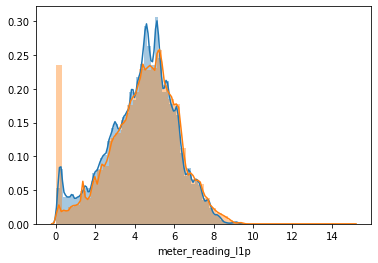

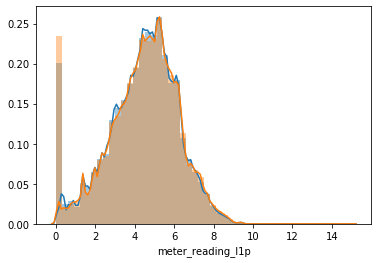

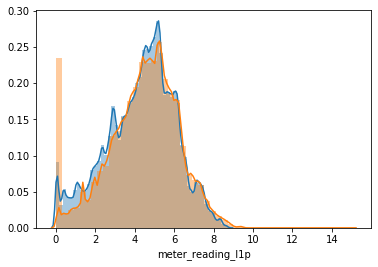

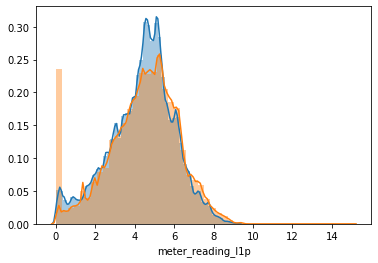

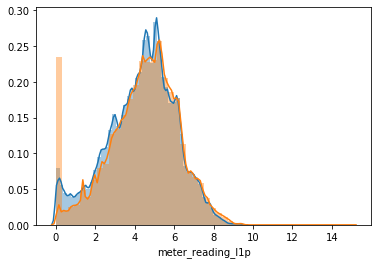

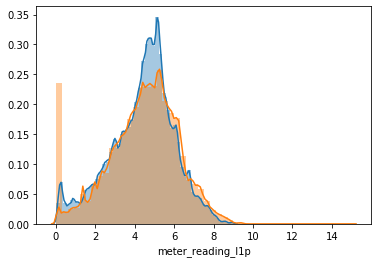

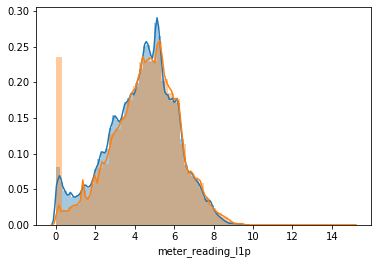

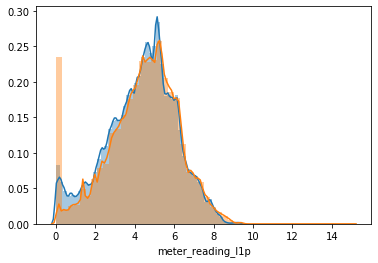

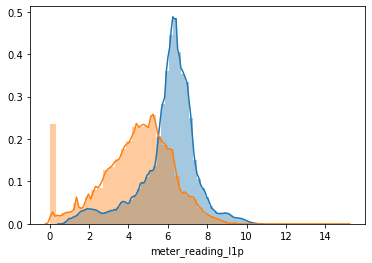

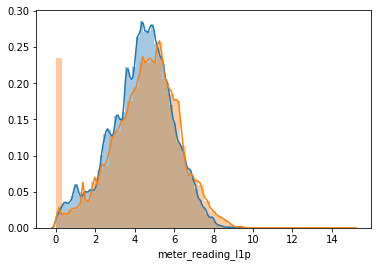

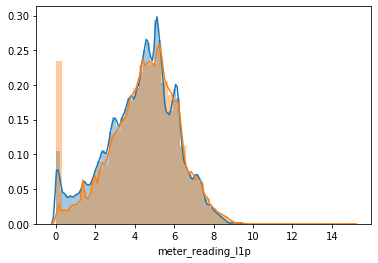

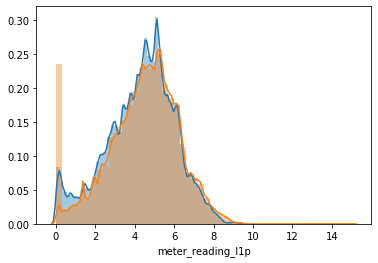

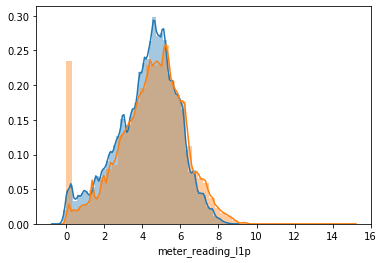

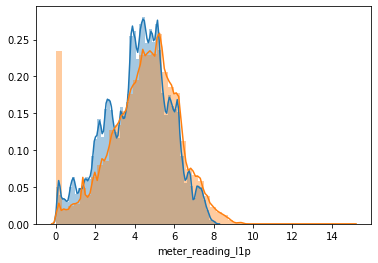

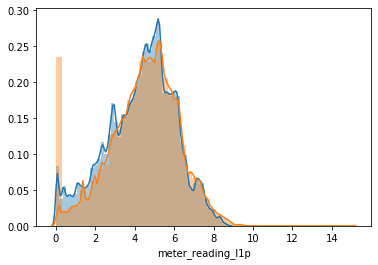

In [130]:
for i in range(len(all_files)):
    print(f'File name: {all_files[i]}')
    fig = plt.figure()
    sns.distplot(leak_df[f'pred_{i + 1}_l1p'])
    sns.distplot(leak_df.meter_reading_l1p)
    
    leak_score = np.sqrt(mean_squared_error(leak_df[f'pred_{i + 1}_l1p'], leak_df.meter_reading_l1p))
    print(f'Score {i + 1} = {leak_score}')

# Leak Validation for Blending

A one idea how we can use LV usefull is blending. We probably can find best blending method without LB probing and it's means we can save our submission.

mean score= 0.965789


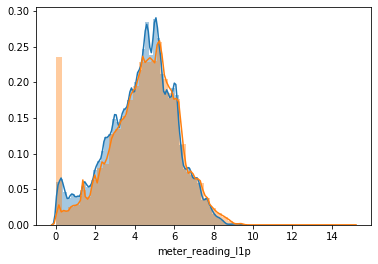

In [137]:
leak_df['mean_pred'] = np.mean(leak_df[['pred_1', 'pred_2', 'pred_5', 'pred_10']].values, axis=1)
leak_df['mean_pred_l1p'] = np.log1p(leak_df.mean_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.mean_pred_l1p, leak_df.meter_reading_l1p))


sns.distplot(leak_df.mean_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print('mean score=', leak_score)

meadian score= 0.9745677


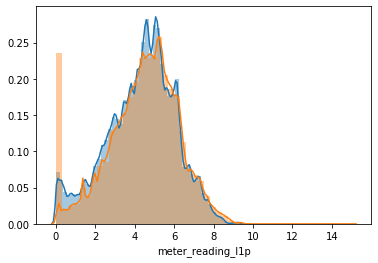

In [25]:
leak_df['median_pred'] = np.median(leak_df[['pred_5', 'pred_7', 'pred_2', 'pred_1']].values, axis=1)
leak_df['median_pred_l1p'] = np.log1p(leak_df.median_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.median_pred_l1p, leak_df.meter_reading_l1p))

sns.distplot(leak_df.median_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('meadian score=', leak_score)

Ummm... it looks mean blending is beter than median blending

# Find Best Weight

In [138]:
N = 10
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v = p * leak_df['pred_10'].values + (1.-p) * leak_df['pred_5'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

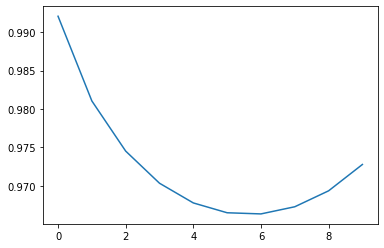

In [139]:
plt.plot(scores)

In [140]:
best_weight = np.argmin(scores) *  1./N
print (scores.min(), best_weight)

0.9663658142089844 0.6


In [141]:
# and more
scores = np.zeros(N,)
for i in range(N):
    p = i * 1./N
    v =  p * (best_weight * leak_df['pred_10'].values + (1.-best_weight) * leak_df['pred_5'].values) + (1.-p) * leak_df['pred_1'].values
    vl1p = np.log1p(v)
    scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

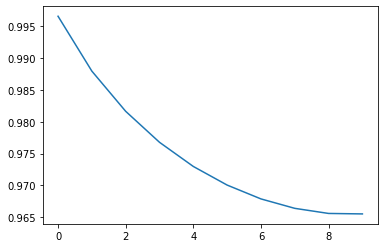

In [142]:
plt.plot(scores)

In [143]:
best_weight2 = np.argmin(scores) *  1./N
print (scores.min(), best_weight2)
# its seams better than simple mean 0.92079717

0.9654970169067383 0.9


# Heuristic way

### Create List of Possible Combinations

In [145]:
all_combinations = list(np.linspace(0.2,0.5,31))
all_combinations

[0.2,
 0.21000000000000002,
 0.22,
 0.23,
 0.24000000000000002,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29000000000000004,
 0.30000000000000004,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42000000000000004,
 0.43000000000000005,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48000000000000004,
 0.49,
 0.5]

### Create List of All Possible Combinations of Three Lists

In [33]:
import itertools

In [146]:
l = [all_combinations, all_combinations, all_combinations]
# remember to do the reverse!
all_l = list(itertools.product(*l)) + list(itertools.product(*reversed(l)))

### Filter Combinations to Have Those With Sum of Weights > 0.95 

Reason being weight sum of 0.96 led to LB score of 0.99

In [147]:
filtered_combis = [l for l in all_l if l[0] + l[1] + l[2] > 0.93 and l[0] + l[1] + l[2] < 1.03]

In [148]:
print(len(filtered_combis))

12142


## Begin the Search For Combination With Lowest Score!

In [149]:
best_combi = [] # of the form (i, score)
for i, combi in enumerate(filtered_combis):
    #print("Now at: " + str(i) + " out of " + str(len(filtered_combis))) # uncomment to view iterations
    score1 = combi[0]
    score2 = combi[1]
    score3 = combi[2]
    v = score1 * leak_df['pred_10'].values + score2 * leak_df['pred_5'].values + score3 * leak_df['pred_1'].values
    vl1p = np.log1p(v)
    curr_score = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
    
    if best_combi:
        prev_score = best_combi[0][1]
        if curr_score < prev_score:
            best_combi[:] = []
            best_combi += [(i, curr_score)]
    else:
        best_combi += [(i, curr_score)]
            
score = best_combi[0][1]
print(score)

0.9640325


# Submit

In [150]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))

# extract best combination
final_combi = filtered_combis[best_combi[0][0]]
w1 = final_combi[0]
w2 = final_combi[1]
w3 = final_combi[2]
print("The weights are: w1=" + str(w1) + ", w2=" + str(w2) + ", w3=" + str(w3))



The weights are: w1=0.43000000000000005, w2=0.31, w3=0.2


In [151]:
sample_submission['meter_reading'] = w1 * test_df.pred_10 +  w2 * test_df.pred_5  + w3 * test_df.pred_1
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [152]:
sample_submission.head()

,row_id,meter_reading
0,0,170.077581
1,1,81.991472
2,2,7.002425
3,3,278.433580
4,4,1153.650702


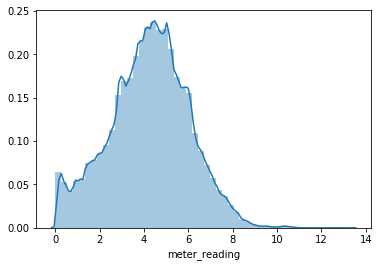

In [153]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [154]:
leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

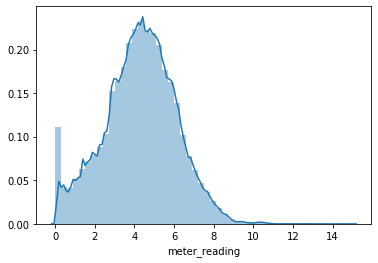

In [155]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [156]:
sample_submission.head(20)

,row_id,meter_reading
0,0,173.370300
1,1,53.512718
2,2,6.143042
3,3,101.701469
4,4,1141.240723
5,5,13.651204
6,6,260.874512
7,7,502.705597
8,8,717.574036
9,9,513.285278


In [157]:
sample_submission.to_csv('submission_blend_2.csv', index=False, float_format='%.4f')

# Future Work

- Increase the range of weights
- Vary tolerance for sum of weights (currently tol = 0.95)